In [355]:
import numpy as np
from scipy.integrate import odeint
from scipy.linalg import solve
from scipy.linalg import norm
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
# np.set_printoptions(suppress=True)

Given the following BVP
\begin{equation}
\frac{d^2v}{dr^2} + \frac{1}{r}\frac{dv}{dr} - v + 2v^3 = 0
\end{equation}
with boundary conditions
\begin{equation}
\frac{dv}{dr}(0)=0,\quad v(\infty)=0.
\end{equation}
We seek to implement the Newton-Kantorovich method to obtain the monotonically decaying and the one node solutions.

Expressing the BVP as
\begin{equation}
F(v)=
\begin{cases}
v'' + \frac{1}{r} v' - v +2v^3=0 \\
v'(0) = 0\\
v(\infty) = 0
\end{cases}
\end{equation}

The Fréchèt derivative is
\begin{equation}
F^{\,\prime}z =
\begin{cases}
\left[\frac{d^2}{dr^2} + \frac{1}{r} \frac{d}{dr} - 1 + 6v^2\right]z\\
z'(0)\\
z(\infty)
\end{cases}
\end{equation}

Then the Newton-Kantorovich equation $F^{\,\prime}z=-F$ is
\begin{equation}
\begin{cases}
\left[\frac{d^2}{dr^2} + \frac{1}{r} \frac{d}{dr} - 1 + 6v^2\right]z = - \left[ v'' + \frac{1}{r}v' - v + 2v^3\right]\\
z'(0) = -v'(0)\\
z(\infty) = -v(\infty)
\end{cases}
\end{equation}

We now want to solve using finite differences. Let $h$ be the space-step such that
\begin{equation}
h=\frac{b-a}{N}
\end{equation}
so there are $N + 1$ points and $N$ spacings between those points with width $h$. 

In [356]:
a, b = [0.001, 10]
N = 10
h = (b - a)/N
r = np.linspace(a, b, N+1)

We require an ansatz $v(r)$. From the shooting method for the decaying solution

In [357]:
def f(v, r):
    return v[1], -(1/r)*v[1] + v[0] - 2*v[0]**3

pstart, pend = [1.5, 2]
tol = 10**(-6)
diff = np.abs(pend - pstart)

while diff > tol:
    updated_p = (pend + pstart)/2
    v0 = [updated_p, 0]
    v = odeint(f, v0, r)

    if v[-1][0] < 0:
        pend = updated_p
    elif v[-1][0] > 0:
        pstart = updated_p

    diff = np.abs(pend - pstart)

v0 = [updated_p, 0]
v = odeint(f, v0, r)
v = v[:,0]


Substituting the centered, backward, and forward finite differences into the Newton-Kantorovich equation 
\begin{align}
\frac{z_{j-1} - 2z_j + z_{j+1}}{h^2} + \frac{1}{r}\frac{z_{j+1} - z_{j-1}}{2h}-z_j + 6v_j^2 z_j &= \frac{v_{j-1}-2v_j+v_{j+1}}{h^2} - \frac{1}{r}\frac{v_{j+1} - v_{j-1}}{2h} + v_j - 2v_{j}^3\\
\frac{-3z_1 + 4z_2 - z_3}{2h} &= -\frac{-3v_1 + 4v_2 - v_3}{2h}\\
z_{N+1} &= -v_{N+1}
\end{align}

Expressing the left hand side in terms of $z$ of the new system
\begin{align}
z_j\left(-\frac{2}{h^2} - 1 + 6v_j^2\right) + z_{j-1}\left(\frac{1}{h^2} - \frac{1}{r}\frac{1}{2h}\right)+z_{j+1}\left(\frac{1}{h^2} + \frac{1}{r}\frac{1}{2h}\right) &= \frac{v_{j-1}-2v_j+v_{j+1}}{h^2} - \frac{1}{r}\frac{v_{j+1} - v_{j-1}}{2h} + v_j - 2v_{j}^3 \\
z_1\left(-\frac{3}{2h}\right) + z_2(2h) + z_3\left(-\frac{1}{2h}\right)&=-\frac{-3v_1 + 4v_2 - v_3}{2h}\\
z_{N+1} &= -v_{N+1}
\end{align}

The system can be expressed as
\begin{equation}
\begin{pmatrix}
-\frac{3}{2h} & 2h & -\frac{1}{2h} & & \cdots & 0\\
\frac{1}{h^2}-\frac{1}{r}\frac{1}{2h} & -\frac{2}{h^2}-1+6v_2^2 & \frac{1}{h^2} + \frac{1}{r}\frac{1}{2h} & & \cdots & 0\\
0 & \frac{1}{h^2}-\frac{1}{r}\frac{1}{2h} & -\frac{2}{h^2}-1+6v_3^2 & \frac{1}{h^2} + \frac{1}{r}\frac{1}{2h} & \cdots & 0\\
\vdots &  &  &  & & \vdots \\
0 & \cdots & & \frac{1}{h^2}-\frac{1}{r}\frac{1}{2h} & -\frac{2}{h^2}-1+6v_N^2 & \frac{1}{h^2} + \frac{1}{r}\frac{1}{2h}\\
0 & 0 & \cdots & 0 & 0 & 1
\end{pmatrix}
\begin{pmatrix}
z_1\\
z_2\\
z_3\\
\vdots\\
z_{N+1}
\end{pmatrix}
=
\begin{pmatrix}
-\frac{-3v_1 + 4v_2 - v_3}{2h}\\
\frac{v_1-2v_2+v_3}{h^2} - \frac{1}{r}\frac{v_3 - v_1}{2h} + v_2 - 2v_{2}^3\\
\frac{v_2-2v_3+v_4}{h^2} - \frac{1}{r}\frac{v_4 - v_2}{2h} + v_3 - 2v_{3}^3\\
\vdots\\
-v_{N+1}
\end{pmatrix}
\end{equation}

Constructing the Jacobian matrix:

In [358]:
jacobian = np.zeros((N+1, N+1))

jacobian[(0, 0)] = -3/(2*h)
jacobian[(0, 1)] = 2*h
jacobian[(0, 2)] = -1/(2*h)
jacobian[(N, N)] = 1

diag_1 = []
diag_2 = []
diag_3 = []

for i in range(1, N):
    diag_1.append(1/(h**2) - (1/r[i])*(1/(2*h)))
    diag_2.append(-2/(h**2) - 1 + 6*v[i]**2)
    diag_3.append(1/(h**2) + (1/r[i])*(1/(2*h)))

np.fill_diagonal(jacobian[1:, :N-1], diag_1)
np.fill_diagonal(jacobian[1:N, 1:N], diag_2)
np.fill_diagonal(jacobian[1:N+1, 2:N+1], diag_3)

print(jacobian)

[[-1.50015002  1.9998     -0.50005001  0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 0.50059967  0.35498396  1.49980039  0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 0.          0.750275   -2.70032324  1.25012506  0.          0.
   0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.83355558 -2.97197552  1.16684448  0.
   0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.87520628 -2.99746128  1.12519378
   0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.90020003 -3.00007877
   1.10020003  0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.91686392
  -3.00036384  1.08353614  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.92

Creating the $-F$ vector:

In [359]:
F = np.zeros((N+1, 1))
F[(0, 0)] = -(-3*v[0] + 4*v[1] - v[2])/(2*h)
F[(N, 0)] = -v[N]

for i in range(1, N):
    F[(i, 0)] = (v[i-1] - 2*v[i] + v[i+1])/(h**2) - (1/r[i])*((v[i+1] - v[i-1])/(2*h)) + v[i] - 2*v[i]**3
    
print(F)


[[ 0.95627943]
 [ 0.86711991]
 [ 0.74041159]
 [ 0.20988684]
 [ 0.06168851]
 [ 0.0192392 ]
 [ 0.00621815]
 [ 0.00202158]
 [ 0.00057031]
 [-0.00009663]
 [ 0.00043345]]


Now we can create the while loop that will iteratively solve for the vector $\vec{z}$

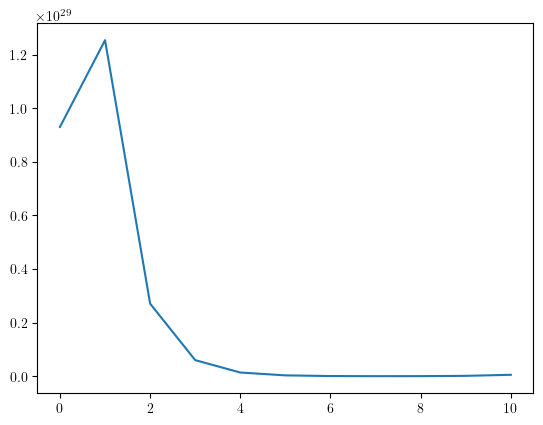

In [360]:
tol = 10**(-6)
n_iterations = 0
z = np.zeros((N+1, 1))

while norm(F) > tol and n_iterations < 100:
    z = solve(jacobian, F)
    F = F + z
    n_iterations = n_iterations + 1
    
plt.plot(r, F)
plt.show()
